In [1]:
import torchvision
import torch.nn as nn 
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
import cv2
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

### Transfer learning using VGG16

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_data_dir = "./data/Cat_and_Dog/training_set/training_set"
test_data_dir = "./data/Cat_and_Dog/test_set/test_set"

In [4]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] 
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [5]:
data = CatsDogs(train_data_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.535425].


tensor([1.], device='cuda:0')


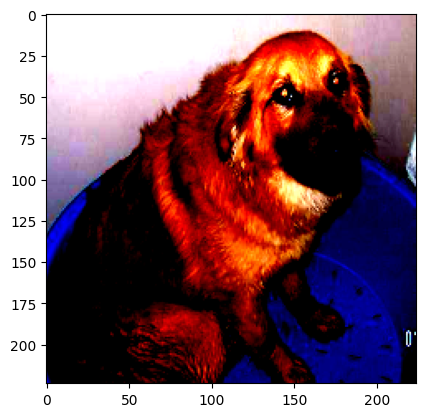

In [6]:
im, label = data[507]
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

In [7]:
def get_model():
    SNet = models.vgg16(pretrained=True)
    for param in SNet.parameters():
        param.requires_grad = False
    SNet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    SNet.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(512, 128),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(128, 1),
                                    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(SNet.parameters(), lr=1e-3)
    return SNet.to(device), loss_fn, optimizer

In [8]:
SNet, criterion, optimizer = get_model()

c:\Users\SANDIP\Desktop\Vscode_projects\Computer_vision\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SANDIP\Desktop\Vscode_projects\Computer_vision\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
summary(SNet, torch.zeros(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [10]:
def train_batch(x, y, SNet, optimizer, loss_fn):
    SNet.train()
    prediction = SNet(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [11]:
@torch.no_grad()
def accuracy(x, y, SNet):
    SNet.eval()
    prediction = SNet(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [12]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [13]:
@torch.no_grad()
def val_loss(x, y, SNet, loss_fn):
    prediction = SNet(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [14]:
trn_dl, val_dl = get_data()
SNet, loss_fn, optimizer = get_model()

In [15]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(f"epoch: {epoch}")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_losses, val_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, SNet, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, SNet)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, SNet)
        validation_loss = val_loss(x, y, SNet, loss_fn)
        val_epoch_accuracies.extend(val_is_correct)
        val_epoch_losses.append(validation_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    val_epoch_loss = np.array(val_epoch_losses).mean()
    print(f"train_loss: {train_epoch_loss} val_loss: {val_epoch_loss}")
    print(f"train_accuracy: {train_epoch_accuracy}, val_accuracy: {val_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch: 0
train_loss: 0.2443617141294864 val_loss: 0.0897471341755121
train_accuracy: 0.9778225806451613, val_accuracy: 0.969758064516129
epoch: 1
train_loss: 0.06152639969161922 val_loss: 0.05886817019012186
train_accuracy: 0.9858870967741935, val_accuracy: 0.9838709677419355
epoch: 2
train_loss: 0.0363482266754633 val_loss: 0.054808591312218095
train_accuracy: 0.9909274193548387, val_accuracy: 0.9838709677419355
epoch: 3
train_loss: 0.027838174674299457 val_loss: 0.05488424237457014
train_accuracy: 0.9929435483870968, val_accuracy: 0.9858870967741935
epoch: 4
train_loss: 0.026969367007334388 val_loss: 0.056716701571619316
train_accuracy: 0.9949596774193549, val_accuracy: 0.9798387096774194


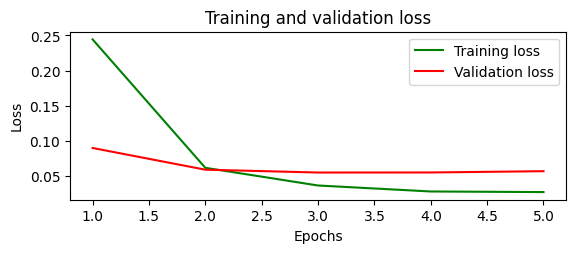

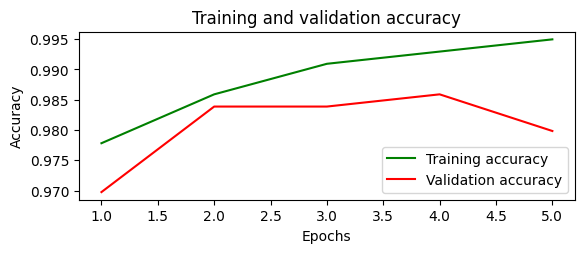

In [16]:
epochs = np.arange(5) + 1
plt.subplot(211)
plt.plot(epochs, train_losses, "g", label="Training loss")
plt.plot(epochs, val_losses, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.subplot(212)
plt.plot(epochs, train_accuracies, "g", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


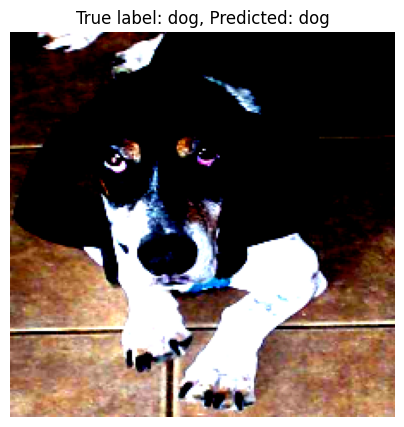

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.64].


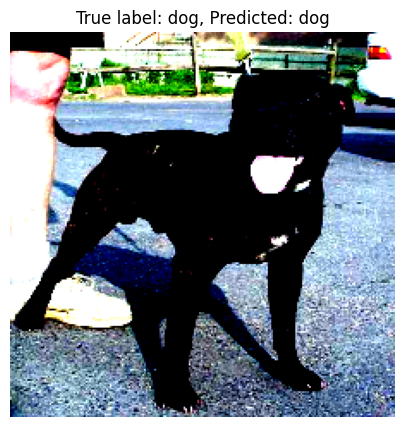

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


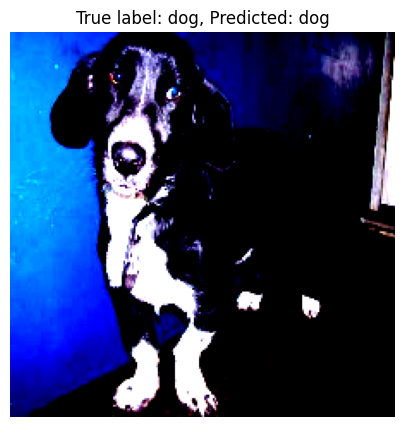

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


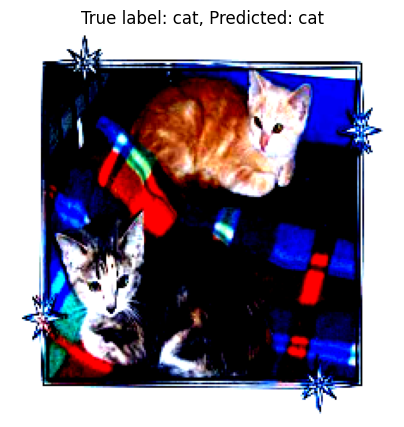

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].


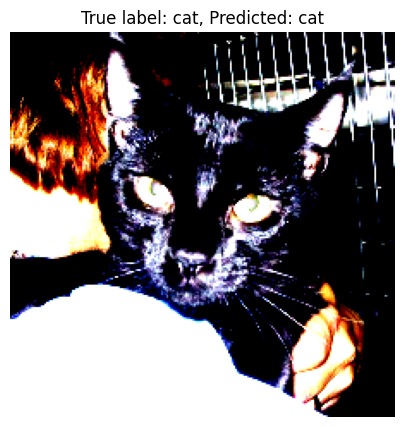

In [17]:
# Function to predict and compare the output
def predict_and_compare(SNet, dataset, device):
    # Set the model to evaluation mode
    SNet.eval()

    # We will go through the first 5 samples in the dataset for this demonstration
    for i in range(5):
        # Get the image and label
        img, label = dataset[i]
        
        # Move the image and label to the device (GPU/CPU)
        img = img.unsqueeze(0).to(device)  # Add batch dimension
        label = label.to(device)

        # Make the prediction
        with torch.no_grad():  # No need to track gradients
            prediction = SNet(img)

        # Convert the prediction to binary (dog or cat)
        predicted_label = (prediction > 0.5).float()
        
        # Convert the image back to the original shape (to plot)
        img = img.squeeze().cpu().numpy().transpose(1, 2, 0)  # Convert from Tensor to NumPy array
        #img = np.clip(img, 0, 1)  # Clip values to [0, 1]

        # Display the image and the prediction
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"True label: {'dog' if label.item() == 1 else 'cat'}, Predicted: {'dog' if predicted_label.item() == 1 else 'cat'}")
        plt.axis('off')
        plt.show()

# Example usage
train_data_dir = train_data_dir  
test_data_dir = test_data_dir   
train = CatsDogs(train_data_dir)
test = CatsDogs(test_data_dir)



# Example of prediction on a single image
predict_and_compare(SNet, test, device)